In [16]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1, 2, 3"
device_ids = [0, 1, 2, 3]
import os.path
from datetime import datetime
from time import time
from torch import nn as nn
import scipy
from matplotlib import pyplot as plt
from tqdm import tqdm

import optuna
from optuna.trial import TrialState
from optuna.integration.wandb import WeightsAndBiasesCallback

import torch
import numpy as np
from tqdm import tqdm
import pandas as pd

from dragonnet import DragonNet

In [5]:
%time train_df =  pd.read_pickle('../../train_data_0205.pkl')
%time test_df =  pd.read_pickle('../../test_data_0205.pkl')

CPU times: user 5.43 s, sys: 8.17 s, total: 13.6 s
Wall time: 13.7 s
CPU times: user 2.69 s, sys: 3.62 s, total: 6.31 s
Wall time: 6.34 s


In [7]:
in_features = ['meta_bitrate_diff', 'wifi_play_ratio', 'playing_time_funny', 'w3_app_use_duration_ks', 'fr_nn_vnus', 'is_photo_author_ks', 'nr_nn_diff_abs', 'w0_app_use_duration_ks', 'meta_bitrate_diff_abs', 'is_live_author', 
               'nr_nn_fast', 'playing_time_sport', 'is_active_7d_ks', 'video_ratio', 'blocky_probability_new', 'mbps_pct30_avg', 'low_catg_ratio', 'upload_days_num_30d', 'playing_time_travel', 'playing_time_animal', 
               'follow_cnt', 'fr_nn_diff_abs', 'meta_bitrate_vnus', 'friend_user_num', 'w1_active_day_ks', 'finish_played_ratio', 'play_cnt_11', 'sum_finish_play_ratio', 'playing_time_star', 'mbps_avg', 'playing_dur_15', 
               'nr_nn_vnus', 'live_days', 'general_score', 'inter_complexity', 'intra_complexity', 'playing_time_news', 'play_cnt_13', 'live_minutes', 'upload_cnt', 'nr_nn_diff', 'mbps_pct50_avg', 'playing_dur_17', 'playing_time_life', 
               'playing_time_game', 'mobile_mbps_overall', 'std_mbps_avg', 'mbps_pct90_avg', 'mbps_pct10_avg', 'playing_dur_14', 'playing_dur_11', '4g_play_ratio', 'playing_time_health', 'playing_dur_16', 'play_cnt_17', 'high_catg_ratio', 
               'playing_time_child', 'follow_user_num', 'upload_photo_num_30d', 'playing_time_rural', 'video_minutes', 'fr_nn_fast', 'playing_time_car', 'memory_kuaishou_score', 'playing_time_religion', 'fr_nn_diff', 
               'play_cnt_15', 'month_app_use_duration_ks', 'play_cnt', 'is_install_xigua', 'total_minutes', 'playing_dur_13', 'mbps_overall', 'play_cnt_16', 'playing_time_3c', 'avg_month_app_use_duration_ks', 
               'playing_time_knowledge', 'play_cnt_14', 'month_active_day_ks', 'playing_time_null', 'wifi_mbps_avg', 'playing_dur', 'playing_time_outfit', 'live_ratio', 'play_cnt_12', '5g_play_ratio', 'w3_active_day_ks', 
               'w1_app_use_duration_ks', 'playing_time_beauty', 'blur_probability_new', 'w2_app_use_duration_ks', 'meta_bitrate_fast', 'playing_time_food', 'w0_active_day_ks', 'playing_time_makeup', 'playing_time_movie', 
               'playing_time_emo', 'playing_time_dance', 'mid_catg_ratio', 'playing_time_carton', 'is_install_douyin', '720p_bitrate_mean', 'playing_dur_12', 'playing_time_military', 'w2_active_day_ks', 'io_kuaishou_score', 
               'playing_time_house', 'active_30d_cnt', 'p_app_platform', 'user_active_degree_ks', 'life_time_ks', 'active_7d_degree', 'user_active_degree', 'gender', 'age_segment', 'fre_community_type', 'fre_city_level', 
               'fre_sourth_north', 'fre_region', 'mod_price_range', 'reg_channel', 'fans_user_num_range', 'author_life_cycle']
categorical_features = ['p_app_platform', 'user_active_degree_ks', 'life_time_ks', 'active_7d_degree', 'user_active_degree', 'gender', 'age_segment', 'fre_community_type', 'fre_city_level', 'fre_sourth_north', 'fre_region', 
                'mod_price_range', 'reg_channel', 'fans_user_num_range', 'author_life_cycle']
label_feature = ['label_log']
treatment_feature = ['groupId']

In [8]:
X_train = train_df[in_features].values
y_train = train_df[label_feature].values
t_train = train_df[treatment_feature].values
X_test = test_df[in_features].values
y_test = test_df[label_feature].values
t_test = test_df[treatment_feature].values

In [22]:
def get_new_df(df, uplift_val, treatment_feature, label_feature):
    new_df = pd.DataFrame(columns = [treatment_feature[0], label_feature[0], uplift_val])
    new_df[treatment_feature[0]] = df[treatment_feature[0]]
    new_df[label_feature[0]] = df[label_feature[0]]
    new_df[uplift_val] = df[uplift_val]
    return new_df
    
def auuc_metric(data, uplift_val, bucket_num, treatment_feature, label_feature, if_return = True, final_test = False):
    # print('label_feature',label_feature)
    new_data = get_new_df(data, uplift_val, treatment_feature, label_feature)
    if final_test:
        del data
    new_data = new_data.sort_values(by=uplift_val, ascending = False)
    # print(bucket_num)
    new_data['bucket'] = pd.qcut(-new_data[uplift_val], bucket_num, labels=False, duplicates='drop')
    # print('====计算完毕====')
    # print('====生成随机数====')
    new_data = new_data.sort_values(by=treatment_feature)
    
    l0, l1 = new_data.loc[new_data[treatment_feature[0]]==0], new_data.loc[new_data[treatment_feature[0]]==1]
    mean0, mean1 = l0[label_feature].values.mean(), l1[label_feature].values.mean()
    print('treatment = 0:', mean0, 'treatment = 1:', mean1)
    r0, r1 = (np.random.rand(len(l0)) - 0.5)/100000 + mean0, (np.random.rand(len(l1)) - 0.5)/100000 + mean1
    print(type(r0))
    new_data['random'] = r0.tolist() + r1.tolist()
    bucket_diff = []
    # print(set(new_data.bucket))
    # print('=========')
    for i in set(new_data.bucket):
        mean_treat = np.mean(new_data.loc[(new_data.bucket == i)&(new_data[treatment_feature[0]] == 1), label_feature].values)
        mean_control = np.mean(new_data.loc[(new_data.bucket == i)&(new_data[treatment_feature[0]] == 0), label_feature].values)
        bucket_diff.append(mean_treat / mean_control - 1)
    plt.ylabel('diff of '+label_feature[0])
    plt.bar(range(len(bucket_diff)),bucket_diff)
    plt.show()
    
    res, population, rand_res, bucket_len = [], [], [], []
    for i in np.arange(0, len(set(new_data.bucket)), 1):
        dbucket = new_data.loc[new_data.bucket <= i]
        db_base = dbucket.loc[dbucket[treatment_feature[0]] == 0]
        db_exp = dbucket.loc[dbucket[treatment_feature[0]] == 1]
        cumugain = (db_exp[label_feature].mean() / db_base[label_feature].mean() - 1) * (len(db_base) + len(db_exp))
        cumu_random = (db_exp['random'].mean() / db_base['random'].mean()- 1 ) * (len(db_base) + len(db_exp))
        population.append(len(db_base) + len(db_exp))
        bucket_len.append(len(new_data[new_data.bucket == i]))
        res.append(cumugain)
        rand_res.append(cumu_random)
    rand_res[-1] = res[-1]
    cumuGain = pd.DataFrame({'cumuGain': res,
                             'population': population,
                             'percent': np.arange(1 / len(set(new_data.bucket)), 1 + 1 / len(set(new_data.bucket)),
                                                  1 / len(set(new_data.bucket))),
                             'random': rand_res})
    
    # 归一化 将值框定在[0，1]之间
    cumugain = cumuGain['cumuGain']
    gap0 = cumugain.iloc[-1].values
    cumugain = [(i) / abs(gap0) for i in cumugain]

    cumu_random = cumuGain['random']
    gap = cumu_random.iloc[-1]
    cumu_random = [(i) / abs(gap) for i in cumu_random]
    
    plt.plot(np.append(0,(np.array(population))/max(population)), np.append(0,cumugain), marker='*', label='pred')
    plt.plot(np.append(0,(np.array(population))/max(population)), np.append(0,cumu_random), marker='*', label='random')
    plt.grid(linestyle='--')
    plt.xlabel('Percent')
    plt.ylabel('Uplift')
    plt.legend()
    plt.show()
    
    # 近似计算cumugain函数和x轴围成的曲线下面积，也就是auuc
    auuc_value, rand = np.trapz(np.append(0, cumugain),np.append(0, (np.array(population))/max(population))),\
                                np.trapz(np.append(0, cumu_random),np.append(0, (np.array(population))/max(population)))
    auuc_value = auuc_value - rand
    spearmanr_value = -scipy.stats.spearmanr(bucket_diff, list(set(new_data.bucket)))[0]
    # print(cumugain, np.array(population)/max(population))
    if gap0 < 0: 
        auuc_value, rand = np.trapz([i + 1 for i in np.append(0, cumugain)], np.append(0,(np.array(population))/max(population))),\
                                    np.trapz([i + 1 for i in np.append(0, cumu_random)], np.append(0,(np.array(population))/max(population)))
        auuc_value = auuc_value - rand
    print('auuc score:', auuc_value, 'random score:', rand)
    print('spearmanr:', spearmanr_value)
    if if_return == True:return data
    else: return auuc_value

In [20]:
def objective(trial):
    params = {
        'epochs': trial.suggest_int('epochs', 40, 70),
        'shared_hidden': trial.suggest_int('shared_hidden', 100, 300),
        'outcome_hidden': trial.suggest_int('outcome_hidden', 50, 150),
        'learning_rate': trial.suggest_float('learning_rate', 1e-6, 1e-3),
        'alpha': trial.suggest_float('alpha', 0.5, 1),
        'beta': trial.suggest_float('beta', 0.5,1),
    }
        
    model = DragonNet(input_dim=X_train.shape[1],shared_hidden=params["shared_hidden"],outcome_hidden=params["outcome_hidden"],
                     alpha=params["alpha"],beta=params["beta"],epochs=params["epochs"])    

    start = time()
    model.fit(X_train, y_train, t_train)
    print(f"Time for realization: {time() - start:.2f}s")

    y0_pred, y1_pred, t_pred, _ = model.predict(X_test)
    y0_pred[y0_pred<0]=0
    y1_pred[y1_pred<0]=0
    test_df['target_dif'] = y1_pred - y0_pred

    auuc_score = auuc_metric(test_df,'target_dif', 5, treatment_feature, label_feature, if_return = False)
    
    return auuc_score

In [13]:
def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

[I 2023-04-19 23:54:57,383] A new study created in memory with name: no-name-4bd1dcf4-01e5-4e4f-8ebc-a4d5270c6626


epoch: 0--------- train_loss: 1090962456576.0
epoch: 1--------- train_loss: 37889810432.0
epoch: 2--------- train_loss: 2377129728.0
epoch: 3--------- train_loss: 1713475840.0
epoch: 4--------- train_loss: 1887931392.0
epoch: 5--------- train_loss: 1233243904.0
epoch: 6--------- train_loss: 1244821760.0
epoch: 7--------- train_loss: 950770368.0
epoch: 8--------- train_loss: 5959100416.0
epoch: 9--------- train_loss: 1744392960.0
epoch: 10--------- train_loss: 2768116992.0
epoch: 11--------- train_loss: 886979776.0
epoch: 12--------- train_loss: 903487104.0
epoch: 13--------- train_loss: 1134802688.0
epoch: 14--------- train_loss: 1866285824.0
epoch: 15--------- train_loss: 1718751488.0
epoch: 16--------- train_loss: 2112213248.0
epoch: 17--------- train_loss: 1231931392.0
epoch: 18--------- train_loss: 2170619904.0
epoch: 19--------- train_loss: 674010304.0
epoch: 20--------- train_loss: 861067328.0
epoch: 21--------- train_loss: 870844288.0
epoch: 22--------- train_loss: 543357952.0
e

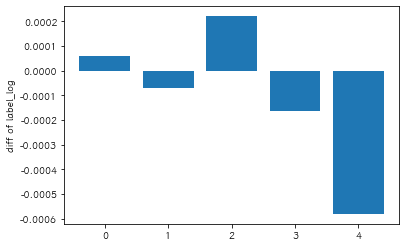

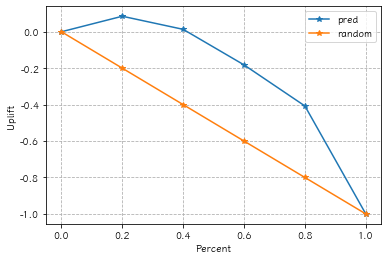

[I 2023-04-20 00:36:36,699] Trial 0 finished with value: 0.3017966366584527 and parameters: {'epochs': 57, 'shared_hidden': 273, 'outcome_hidden': 83, 'learning_rate': 0.0002473234577434573, 'alpha': 0.9049880518680904, 'beta': 0.7000784699511162}. Best is trial 0 with value: 0.3017966366584527.


auuc score: 0.3017966366584527 random score: 0.49999925128796585
spearmanr: 0.7
epoch: 0--------- train_loss: 4373452685312.0
epoch: 1--------- train_loss: 376668225536.0
epoch: 2--------- train_loss: 14466467840.0
epoch: 3--------- train_loss: 82479071232.0
epoch: 4--------- train_loss: 10091179008.0
epoch: 5--------- train_loss: 18018906112.0
epoch: 6--------- train_loss: 19584331776.0
epoch: 7--------- train_loss: 3098907136.0
epoch: 8--------- train_loss: 3314153472.0
epoch: 9--------- train_loss: 5437992960.0
epoch: 10--------- train_loss: 50104606720.0
epoch: 11--------- train_loss: 71089963008.0
epoch: 12--------- train_loss: 9831260160.0
epoch: 13--------- train_loss: 9921218560.0
epoch: 14--------- train_loss: 7679754240.0
epoch: 15--------- train_loss: 10986764288.0
epoch: 16--------- train_loss: 4679377920.0
epoch: 17--------- train_loss: 2416735232.0
epoch: 18--------- train_loss: 1639882496.0
epoch: 19--------- train_loss: 2388092928.0
epoch: 20--------- train_loss: 195234

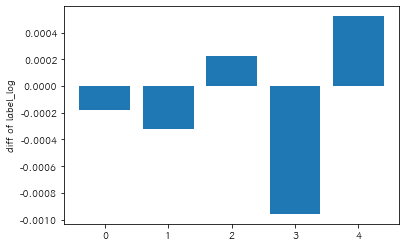

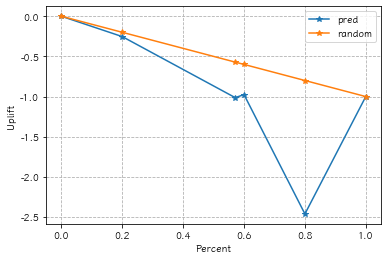

[I 2023-04-20 01:05:37,919] Trial 1 finished with value: -0.4789758632807104 and parameters: {'epochs': 59, 'shared_hidden': 169, 'outcome_hidden': 88, 'learning_rate': 0.0009533434875509624, 'alpha': 0.6075045218797794, 'beta': 0.9052657127578474}. Best is trial 0 with value: 0.3017966366584527.


auuc score: -0.4789758632807104 random score: 0.49999957715348275
spearmanr: -0.3
epoch: 0--------- train_loss: 966214287360.0
epoch: 1--------- train_loss: 35274138583040.0
epoch: 2--------- train_loss: 908870811648.0
epoch: 3--------- train_loss: 188093497344.0
epoch: 4--------- train_loss: 21239218176.0
epoch: 5--------- train_loss: 23642335232.0
epoch: 6--------- train_loss: 6290361344.0
epoch: 7--------- train_loss: 4988167680.0
epoch: 8--------- train_loss: 2428045824.0
epoch: 9--------- train_loss: 1980854272.0
epoch: 10--------- train_loss: 1713916800.0
epoch: 11--------- train_loss: 1587848448.0
epoch: 12--------- train_loss: 1402248064.0
epoch: 13--------- train_loss: 1291398656.0
epoch: 14--------- train_loss: 1175065088.0
epoch: 15--------- train_loss: 1079230976.0
epoch: 16--------- train_loss: 4455584768.0
epoch: 17--------- train_loss: 3493016832.0
epoch: 18--------- train_loss: 32684593152.0
epoch: 19--------- train_loss: 7759020544.0
epoch: 20--------- train_loss: 4738

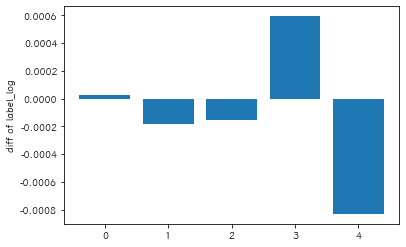

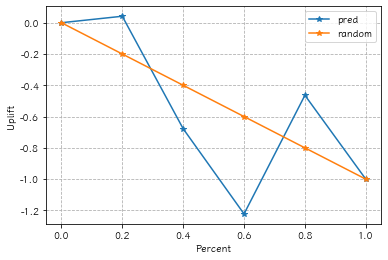

[I 2023-04-20 01:38:22,154] Trial 2 finished with value: -0.06450529370602709 and parameters: {'epochs': 53, 'shared_hidden': 165, 'outcome_hidden': 144, 'learning_rate': 0.0002868371324249625, 'alpha': 0.8866482163910778, 'beta': 0.9648159848370059}. Best is trial 0 with value: 0.3017966366584527.


auuc score: -0.06450529370602709 random score: 0.5000012827821702
spearmanr: 0.3
epoch: 0--------- train_loss: 19360389267456.0
epoch: 1--------- train_loss: 41481830400.0
epoch: 2--------- train_loss: 3424503808.0
epoch: 3--------- train_loss: 120421318656.0
epoch: 4--------- train_loss: 113995513856.0
epoch: 5--------- train_loss: 6118923264.0
epoch: 6--------- train_loss: 3396677888.0
epoch: 7--------- train_loss: 1121988352.0
epoch: 8--------- train_loss: 11657329664.0
epoch: 9--------- train_loss: 2591272960.0
epoch: 10--------- train_loss: 6857635328.0
epoch: 11--------- train_loss: 1366283264.0
epoch: 12--------- train_loss: 1282143744.0
epoch: 13--------- train_loss: 1696089472.0
epoch: 14--------- train_loss: 981668160.0
epoch: 15--------- train_loss: 832922752.0
epoch: 16--------- train_loss: 2835451392.0
epoch: 17--------- train_loss: 4495851008.0
epoch: 18--------- train_loss: 3396520448.0
epoch: 19--------- train_loss: 2156939008.0
epoch: 20--------- train_loss: 6992389632

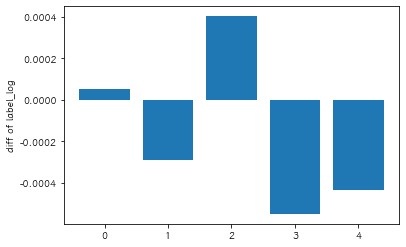

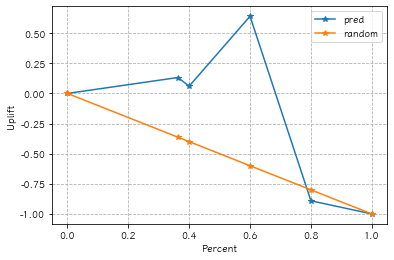

[I 2023-04-20 02:24:22,292] Trial 3 finished with value: 0.3835419151413026 and parameters: {'epochs': 62, 'shared_hidden': 276, 'outcome_hidden': 106, 'learning_rate': 0.0005777893693491769, 'alpha': 0.7357497523848653, 'beta': 0.5367757776772992}. Best is trial 3 with value: 0.3835419151413026.


auuc score: 0.3835419151413026 random score: 0.4999994274496901
spearmanr: 0.6
epoch: 0--------- train_loss: 20880667181056.0
epoch: 1--------- train_loss: 1531671216128.0
epoch: 2--------- train_loss: 5469133824.0
epoch: 3--------- train_loss: 1828334592.0
epoch: 4--------- train_loss: 627006656.0
epoch: 5--------- train_loss: 772139968.0
epoch: 6--------- train_loss: 792721984.0
epoch: 7--------- train_loss: 3658961664.0
epoch: 8--------- train_loss: 6059349504.0
epoch: 9--------- train_loss: 990416768.0
epoch: 10--------- train_loss: 508585472.0
epoch: 11--------- train_loss: 396724096.0
epoch: 12--------- train_loss: 404015296.0
epoch: 13--------- train_loss: 323579520.0
epoch: 14--------- train_loss: 285012704.0
epoch: 15--------- train_loss: 252403488.0
epoch: 16--------- train_loss: 268030016.0
epoch: 17--------- train_loss: 2529394176.0
epoch: 18--------- train_loss: 9344679936.0
epoch: 19--------- train_loss: 3750531584.0
epoch: 20--------- train_loss: 2229035264.0
epoch: 21--

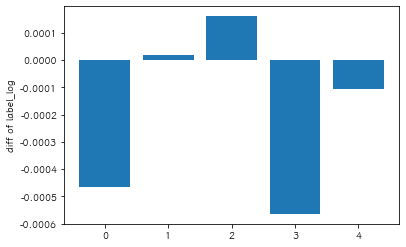

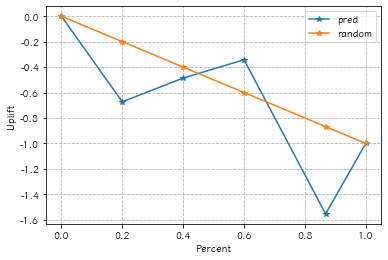

[I 2023-04-20 03:06:56,804] Trial 4 finished with value: -0.18883258510604284 and parameters: {'epochs': 62, 'shared_hidden': 271, 'outcome_hidden': 141, 'learning_rate': 0.0009550663643698046, 'alpha': 0.7268358933744292, 'beta': 0.771211169957793}. Best is trial 3 with value: 0.3835419151413026.


auuc score: -0.18883258510604284 random score: 0.5000019270085405
spearmanr: 0.09999999999999999
epoch: 0--------- train_loss: 276534198272.0
epoch: 1--------- train_loss: 4665028608.0
epoch: 2--------- train_loss: 21348417536.0
epoch: 3--------- train_loss: 204395315200.0
epoch: 4--------- train_loss: 1527425269760.0
epoch: 5--------- train_loss: 197255331840.0
epoch: 6--------- train_loss: 187948826624.0
epoch: 7--------- train_loss: 118996074496.0
epoch: 8--------- train_loss: 1251044992.0
epoch: 9--------- train_loss: 2575031296.0
epoch: 10--------- train_loss: 2870162944.0
epoch: 11--------- train_loss: 1160966656.0
epoch: 12--------- train_loss: 845793472.0
epoch: 13--------- train_loss: 721402880.0
epoch: 14--------- train_loss: 617555072.0
epoch: 15--------- train_loss: 539061696.0
epoch: 16--------- train_loss: 472105152.0
epoch: 17--------- train_loss: 427467776.0
epoch: 18--------- train_loss: 394227264.0
epoch: 19--------- train_loss: 425561856.0
epoch: 20--------- train_lo

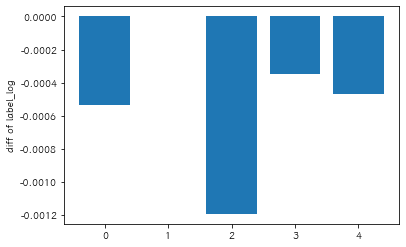

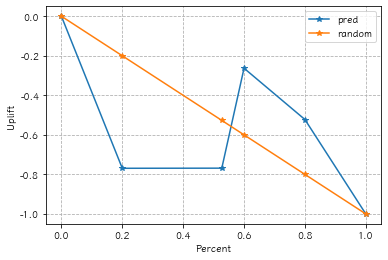

[I 2023-04-20 03:28:59,890] Trial 5 finished with value: -0.09674001875768012 and parameters: {'epochs': 46, 'shared_hidden': 167, 'outcome_hidden': 51, 'learning_rate': 0.0004891017155571399, 'alpha': 0.8763283870225023, 'beta': 0.7191227329659532}. Best is trial 3 with value: 0.3835419151413026.


auuc score: -0.09674001875768012 random score: 0.49999961455789893
spearmanr: -0.09999999999999999
epoch: 0--------- train_loss: 35601210408960.0
epoch: 1--------- train_loss: 9138283216896.0
epoch: 2--------- train_loss: 41787842560.0
epoch: 3--------- train_loss: 5189497856.0
epoch: 4--------- train_loss: 3814534144.0
epoch: 5--------- train_loss: 1337281664.0
epoch: 6--------- train_loss: 3458973184.0
epoch: 7--------- train_loss: 14985090048.0
epoch: 8--------- train_loss: 24491921408.0
epoch: 9--------- train_loss: 12323493888.0
epoch: 10--------- train_loss: 31742558208.0
epoch: 11--------- train_loss: 3901786947584.0
epoch: 12--------- train_loss: 11888265216.0
epoch: 13--------- train_loss: 4075024640.0
epoch: 14--------- train_loss: 3291950848.0
epoch: 15--------- train_loss: 2553263360.0
epoch: 16--------- train_loss: 4022075904.0
epoch: 17--------- train_loss: 1953970176.0
epoch: 18--------- train_loss: 5378372608.0
epoch: 19--------- train_loss: 2283020288.0
epoch: 20------

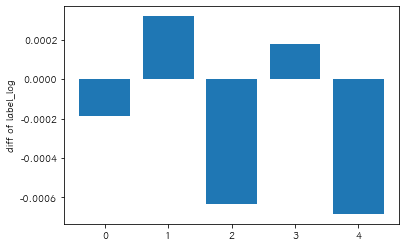

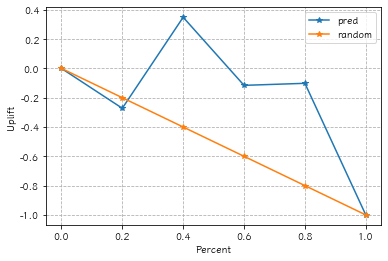

[I 2023-04-20 04:16:25,336] Trial 6 finished with value: 0.37194742188484525 and parameters: {'epochs': 64, 'shared_hidden': 295, 'outcome_hidden': 52, 'learning_rate': 0.00034309548758133313, 'alpha': 0.5741614937297335, 'beta': 0.9338056737878729}. Best is trial 3 with value: 0.3835419151413026.


auuc score: 0.37194742188484525 random score: 0.4999989959484858
spearmanr: 0.49999999999999994
epoch: 0--------- train_loss: 4886720675840.0
epoch: 1--------- train_loss: 61294686208.0
epoch: 2--------- train_loss: 10812372992.0
epoch: 3--------- train_loss: 5809225728.0
epoch: 4--------- train_loss: 4450859520.0
epoch: 5--------- train_loss: 5142386688.0
epoch: 6--------- train_loss: 17418270720.0
epoch: 7--------- train_loss: 14687679488.0
epoch: 8--------- train_loss: 5895625728.0
epoch: 9--------- train_loss: 3994344960.0
epoch: 10--------- train_loss: 3108489728.0
epoch: 11--------- train_loss: 5474095616.0
epoch: 12--------- train_loss: 5174082560.0
epoch: 13--------- train_loss: 22668988416.0
epoch: 14--------- train_loss: 4315107840.0
epoch: 15--------- train_loss: 1411361920.0
epoch: 16--------- train_loss: 974172800.0
epoch: 17--------- train_loss: 849545728.0
epoch: 18--------- train_loss: 642419136.0
epoch: 19--------- train_loss: 494759744.0
epoch: 20--------- train_loss:

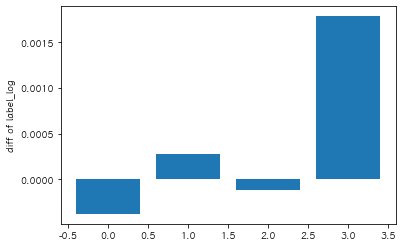

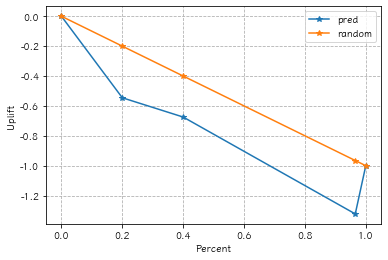

[I 2023-04-20 04:51:36,689] Trial 7 finished with value: -0.28132653700585364 and parameters: {'epochs': 70, 'shared_hidden': 142, 'outcome_hidden': 114, 'learning_rate': 0.0002866407855263629, 'alpha': 0.6898080866547699, 'beta': 0.5758633366811359}. Best is trial 3 with value: 0.3835419151413026.


auuc score: -0.28132653700585364 random score: 0.49999819037933774
spearmanr: -0.7999999999999999
epoch: 0--------- train_loss: 131435438080.0
epoch: 1--------- train_loss: 11968653312.0
epoch: 2--------- train_loss: 54804881408.0
epoch: 3--------- train_loss: 426103734272.0
epoch: 4--------- train_loss: 48826408960.0
epoch: 5--------- train_loss: 4079569408.0
epoch: 6--------- train_loss: 4198617088.0
epoch: 7--------- train_loss: 2618826752.0
epoch: 8--------- train_loss: 2528607744.0
epoch: 9--------- train_loss: 361960701952.0
epoch: 10--------- train_loss: 1895235584000.0
epoch: 11--------- train_loss: 146976948224.0
epoch: 12--------- train_loss: 1045666688.0
epoch: 13--------- train_loss: 895891328.0
epoch: 14--------- train_loss: 552961536.0
epoch: 15--------- train_loss: 537104704.0
epoch: 16--------- train_loss: 5158170624.0
epoch: 17--------- train_loss: 819520064.0
epoch: 18--------- train_loss: 981604992.0
epoch: 19--------- train_loss: 663576064.0
epoch: 20--------- train

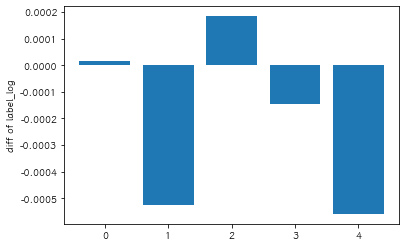

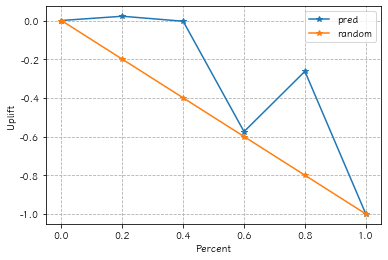

[I 2023-04-20 05:28:32,754] Trial 8 finished with value: 0.23615342001156858 and parameters: {'epochs': 57, 'shared_hidden': 269, 'outcome_hidden': 50, 'learning_rate': 0.0006316698090856936, 'alpha': 0.734290457779754, 'beta': 0.8948818207484409}. Best is trial 3 with value: 0.3835419151413026.


auuc score: 0.23615342001156858 random score: 0.49999930488730004
spearmanr: 0.49999999999999994
epoch: 0--------- train_loss: 449635778560.0
epoch: 1--------- train_loss: 19407943680.0
epoch: 2--------- train_loss: 72779710464.0
epoch: 3--------- train_loss: 12604087296.0
epoch: 4--------- train_loss: 6521743360.0
epoch: 5--------- train_loss: 4518651392.0
epoch: 6--------- train_loss: 2849537024.0
epoch: 7--------- train_loss: 3490038272.0
epoch: 8--------- train_loss: 3513951744.0
epoch: 9--------- train_loss: 22889168896.0
epoch: 10--------- train_loss: 93315604480.0
epoch: 11--------- train_loss: 2776474368.0
epoch: 12--------- train_loss: 2166038784.0
epoch: 13--------- train_loss: 2193689600.0
epoch: 14--------- train_loss: 2044781056.0
epoch: 15--------- train_loss: 1434135040.0
epoch: 16--------- train_loss: 1386713472.0
epoch: 17--------- train_loss: 1372752000.0
epoch: 18--------- train_loss: 1521747200.0
epoch: 19--------- train_loss: 29191151616.0
epoch: 20--------- train_

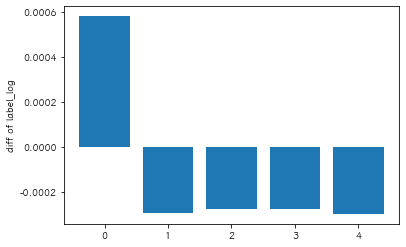

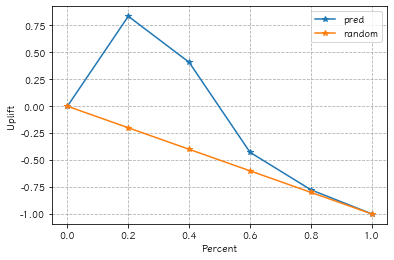

[I 2023-04-20 05:48:39,648] Trial 9 finished with value: 0.40784778419675183 and parameters: {'epochs': 41, 'shared_hidden': 125, 'outcome_hidden': 88, 'learning_rate': 0.0002536373883845273, 'alpha': 0.520973421085487, 'beta': 0.7999649009913798}. Best is trial 9 with value: 0.40784778419675183.


auuc score: 0.40784778419675183 random score: 0.4999978593367731
spearmanr: 0.6
Study statistics: 
Number of finished trials:  10
Number of pruned trials:  0
Number of complete trials:  10
Best trial:
Value:  0.40784778419675183
Params: 
epochs: 41
shared_hidden: 125
outcome_hidden: 88
learning_rate: 0.0002536373883845273
alpha: 0.520973421085487
beta: 0.7999649009913798


In [23]:
now = datetime.now()
str_date_time = now.strftime("%d-%m-%Y_%H-%M-%S")
set_random_seed(0)


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)#, callbacks=[wandbc])
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
print("Study statistics: ")
print("Number of finished trials: ", len(study.trials))
print("Number of pruned trials: ", len(pruned_trials))
print("Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("Value: ", trial.value)

print("Params: ")
for key, value in trial.params.items():
    print("{}: {}".format(key, value))

In [ ]:
print("hello")